<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/pytorch/blob/main/detecting-emotions-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you will learn
1. Using Kaggle and importing Kaggle datasets
1. Reading a dataset of images using ImageFolder
1. Using Dropout to reduce overfitting

### CODE CELL 1

In [1]:
import torch
import torch.nn as nn
import torchvision as vision
from torchvision.transforms import Lambda,Compose,ToTensor,Normalize,Grayscale,ToPILImage
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

## The data
The data is stored on Kaggle. If you are running this notebook on 
1. Kaggle do the following
    1. Using the right panel click on "Add Data"
    1. Use the search keywords "manas sambare fer-2013"
    1. Click on the "+"
    1. The data is accessible from "/kaggle/input/fer2013" (see below)
1. Google Colab do the following:
    1. Go to your Kaggle account and click on your profile
    1. Click on "Account"
    1. Toward the middle of the page click on "Create new API token"
    1. A file "kaggle.json" will be downloaded. Remember where it was saved

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

## If you are running on Kaggle

### CODE CELL 2

In [3]:
transform=Compose([Grayscale(),ToTensor()])
if not IN_COLAB:
  dataset_train=datasets.ImageFolder("/kaggle/input/fer2013/train",transform=transform)
  dataset_test=datasets.ImageFolder("/kaggle/input/fer2013/test",transform=transform)


## If you are running on Colab

### CODE CELL 3

The ```ImageFolder``` class automatically associates with each image the name of the folder it was found in.
After you run the cell below, open the folder in the left pannel and you will see a directory structure that contains ```train/angry,train,disgust,...```
Each image in ```train/angry``` will be given the label "angry" (actually 0) and so on.

In [4]:
if IN_COLAB:
  from google.colab import files
  file=files.upload()
  !mkdir /root/.kaggle
  !mv kaggle.json  /root/.kaggle
  !kaggle datasets download -d msambare/fer2013
  !unzip fer2013.zip>/dev/null
  transform=Compose([Grayscale(),ToTensor()])
  dataset_train=datasets.ImageFolder("train",transform=transform)
  dataset_test=datasets.ImageFolder("test",transform=transform)


Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
print("There are {} samples each with the following categories \n {}".format(
      len(dataset_train),dataset_train.classes))

There are 28709 samples each with the following categories 
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### CODE CELL 4

Like always we plot the images to get an idea about the data

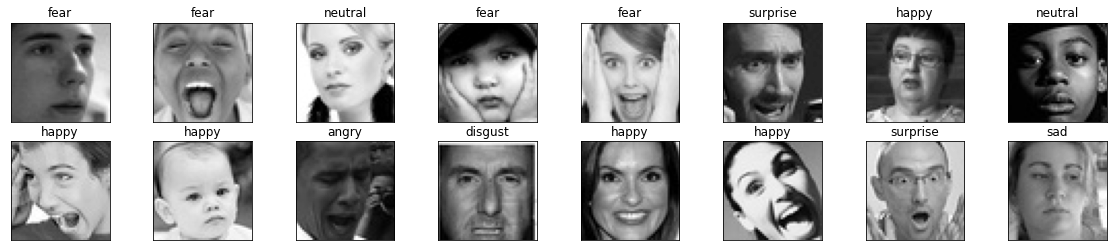

In [6]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,4))
fig.tight_layout()
#plt.subplots_adjust( wspace=1, hspace=1)
to_image=ToPILImage()
for i in range(16):
            idx=torch.randint(len(dataset_test),size=(1,)).item()
            img,label=dataset_test[idx]
            t=fig.add_subplot(2,8,i+1)
            # set the title of the image equal to its label
            t.set_title(dataset_test.classes[label])
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(to_image(img),cmap='gray')

### CODE CELL 5

In [7]:
train_loader=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2,pin_memory=True)
test_loader=DataLoader(dataset_test,batch_size=64,shuffle=False,num_workers=2,pin_memory=True)

## Model

### CODE CELL 6

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu=nn.ReLU()
        self.flatten=nn.Flatten()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        self.drop1=nn.Dropout()
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        self.drop2=nn.Dropout()
        self.fc1=nn.Linear(in_features=9*9*256,out_features=1024)
        self.drop3=nn.Dropout()
        self.fc2=nn.Linear(in_features=1024,out_features=7)
    def forward(self,x):
        #input (1,48,48)
        x=self.conv1(x)
        x=self.relu(x)
        #input (32,46,46)
        x=self.conv2(x)
        x=self.relu(x)
        #input (64,44,44)
        x=self.pool1(x)
        x=self.drop1(x)
        
        #input (64,22,22)
        x=self.conv3(x)
        x=self.relu(x)
        #input (128,20,20)
        x=self.conv4(x)
        x=self.relu(x)
        #input (256,18,18)
        x=self.pool2(x)
        x=self.drop2(x)
        #input (256,9,9)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.drop3(x)
        x=self.fc2(x)
        return x

### CODE CELL 7

Instantiate mode, optimizer and loss function. Then learning loop.

In [9]:
%%time
import torch.optim as optim
model=Net().cuda()
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())

from tqdm import tqdm
epochs=10

for epoch in range(epochs):
    print(f"epoch {epoch}:",end=' ')
    train_loader=tqdm(train_loader)
    epoch_loss=0.0
    for imgs,labels in train_loader:
        imgs=imgs.cuda()
        labels=labels.cuda()
        outputs=model(imgs)
        optimizer.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    print(epoch_loss)
    
        

epoch 0: 

100%|██████████| 449/449 [00:20<00:00, 22.00it/s]


764.5537195205688
epoch 1: 

100%|██████████| 449/449 [00:13<00:00, 34.03it/s]


663.6124331951141
epoch 2: 

100%|██████████| 449/449 [00:13<00:00, 34.33it/s]


600.4339379072189
epoch 3: 

100%|██████████| 449/449 [00:13<00:00, 33.96it/s]


565.4449389576912
epoch 4: 

100%|██████████| 449/449 [00:13<00:00, 33.82it/s]


538.5977990031242
epoch 5: 

100%|██████████| 449/449 [00:13<00:00, 33.86it/s]


511.82029163837433
epoch 6: 

100%|██████████| 449/449 [00:13<00:00, 33.51it/s]


489.9074898958206
epoch 7: 

100%|██████████| 449/449 [00:13<00:00, 33.21it/s]


468.5235720872879
epoch 8: 

100%|██████████| 449/449 [00:13<00:00, 33.26it/s]


455.17943674325943
epoch 9: 

100%|██████████| 449/449 [00:13<00:00, 33.48it/s]

435.97954362630844
CPU times: user 2min 4s, sys: 5.6 s, total: 2min 9s
Wall time: 2min 25s


### CODE CELL 8

In [10]:
# save the model to a file
torch.save(model,'model.h5')

### CODE CELL 9
Install and use torchmetrics

In [11]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(num_classes=7)
conmat=conmat.cuda()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 31.1 MB/s 


In [12]:
# load the model from the file
model=torch.load('model.h5')
total=len(dataset_test)
correct=0
for imgs,labels in test_loader:
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    _,predicted=torch.max(outputs.data,1)
    tmp=(predicted==labels).sum()
    correct+=tmp
    conmat.update(predicted,labels)
print(correct/total)

tensor(0.5359, device='cuda:0')


In [13]:
import matplotlib.pyplot as plt
import seaborn as sb

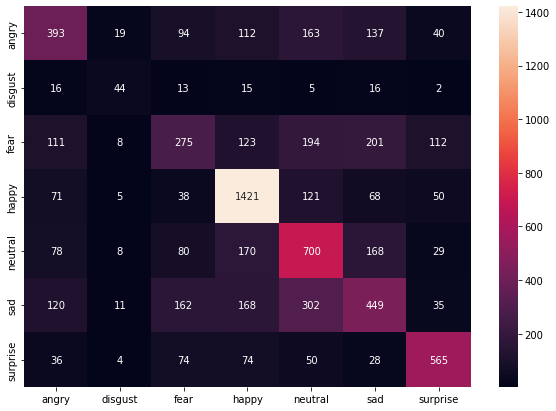

In [14]:
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")